# Visualizations for chapter 4

In [1]:
# import 

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime

from dateutil.relativedelta import relativedelta
import glob
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy    as np
#import networkx as nx
from operator import itemgetter
import pandas   as pd
import rdflib as rdflib
import re
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST, TURTLE
import sys
from rdflib.namespace import XSD, Namespace
from rdflib.term import URIRef

import IPython
import pprint
pp = pprint.PrettyPrinter(indent=4)



from constants import *
from helpers import *

import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy    as np

#set_theme() 
sns.set_theme(style="white",palette="PuOr_r")

In [2]:
end_year=2020
start_year=1971
period_length=5
year_range = end_year - start_year
modulo = year_range % period_length
if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
final_end = end_year + 1

starts = np.arange(start_year, final_start, period_length).tolist()
tuples = [(start, start+period_length) for start in starts]
# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')
original_labels = list(bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))
label_dict.values()

dict_values(['1971 - 1975', '1976 - 1980', '1981 - 1985', '1986 - 1990', '1991 - 1995', '1996 - 2000', '2001 - 2005', '2006 - 2010', '2011 - 2015', '2016 - 2020'])

In [3]:
# helper functions

def to_df(reslist, sort_column):
    my_df=pd.DataFrame(reslist).sort_values(by=sort_column)
    if "year" in my_df.columns:
        my_df["year"]=pd.to_numeric(my_df["year"])
    return my_df


# add period function
def add_period(df_fo, columnname="year"):
    df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
    df_fo['period'] = df_fo['period'].astype("str")

    df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return df_fo

# decade function
def add_decade(df_fi, columname="year"):
    df_fi["decade"]=(df_fi["year"]-1)- ((df_fi["year"]-1)%10)
    
    return df_fi

In [4]:
# datasets

df_fi=pd.read_csv("../../data/df_fi_all2.csv", sep="\t", index_col=0)
df_fo=pd.read_csv("../../data/df_fo_all.csv", sep="\t", index_col=0)
df_fo2=pd.read_csv("../../data/df_fo_all2.csv", sep="\t", index_col=0)

In [5]:
df_fo.drop_duplicates(["year","author","nat","gender","novel","lang","genre","publisher"])#, df_fo2.novel.nunique()

,year,author,nat,gender,novel,lang,publisher,pubName,genre,year_genre,lang_genre,author_genre,decade
0,1984,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_8105,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,NaN,NaN,NaN,NaN,NaN
1,2005,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_1981,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,NaN,NaN,NaN,NaN
2,2005,http://www.yso.fi/onto/kaunokki#person_1231759...,http://seco.tkk.fi/saha3/u4efb5155-076b-4800-9...,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_1981,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,NaN,NaN,NaN,NaN
3,2015,http://www.yso.fi/onto/kaunokki#person_1231758...,http://www.yso.fi/onto/koko/p6292,http://www.yso.fi/onto/kaunokki#male,http://www.btj.fi/at_1674759,http://lexvo.org/id/iso639-3/dan,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Gummerus Kustannus Oy,jannitys,2015.0,http://lexvo.org/id/iso639-3/dan,http://www.yso.fi/onto/kaunokki#person_1231758...,2010.0
4,2011,http://www.btj.fi/actor_Hogan%2C+Chuck,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://www.btj.fi/at_1553291,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Tammi,jannitys,2011.0,http://lexvo.org/id/iso639-3/eng,http://www.btj.fi/actor_Hogan%2C+Chuck,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240,2011,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://www.btj.fi/at_1591998,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,NaN,NaN,NaN,NaN,NaN
20241,1996,http://www.yso.fi/onto/kaunokki#character_1231...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_5288,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Karisto Oy,rakkaus,1996.0,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1990.0
20243,1996,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,unk,http://www.yso.fi/onto/kaunokki#ateos_5288,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Karisto Oy,rakkaus,1996.0,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#person_1231759...,1990.0
20245,1978,http://seco.tkk.fi/saha3/u0548430a-0211-458d-8...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#male,http://seco.tkk.fi/saha3/u66fb0c24-e465-4722-b...,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Gummerus Kustannus Oy,jannitys,1978.0,http://lexvo.org/id/iso639-3/eng,http://seco.tkk.fi/saha3/u0548430a-0211-458d-8...,1970.0


In [6]:
df_fo2.drop_duplicates(["year","author","nat","gender","novel","lang","genre"])

,year,author,nat,gender,novel,lang,publisher,pubName,genre,decade
0,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_8518,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,NaN,NaN
1,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_23787,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Gummerus Kustannus Oy,jannitys,1970.0
2,1971,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#male,http://www.btj.fi/at_1479755,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,jannitys,1970.0
3,1971,http://seco.tkk.fi/saha3/u93bae653-78a3-4a7a-a...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u7d29e490-f7c3-48ca-b...,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,NaN
4,1971,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p12201,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_6328,http://lexvo.org/id/iso639-3/ita,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Weilin + Göös,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
19396,2020,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7047819,http://lexvo.org/id/iso639-3/est,http://data.kirjasampo.fi/actor_Lector+Kustannus,Lector Kustannus Oy,jannitys,2010.0
19397,2020,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_4435226,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Karisto Oy,jannitys,2010.0
19398,2020,http://data.kirjasampo.fi/actor_Sehlstedt%2C+K...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_6986740,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Like,jannitys,2010.0
19399,2020,http://data.kirjasampo.fi/actor_Harris%2C+Neil...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7094878,http://lexvo.org/id/iso639-3/eng,http://data.kirjasampo.fi/actor_Aula+%26+Co,Kustannusosakeyhtiö Aula & Co,NaN,NaN


In [7]:
df_fo2.groupby("year")["novel"].nunique()==df_fo.groupby("year")["novel"].nunique() 

year
1971    True
1972    True
1973    True
1974    True
1975    True
1976    True
1977    True
1978    True
1979    True
1980    True
1981    True
1982    True
1983    True
1984    True
1985    True
1986    True
1987    True
1988    True
1989    True
1990    True
1991    True
1992    True
1993    True
1994    True
1995    True
1996    True
1997    True
1998    True
1999    True
2000    True
2001    True
2002    True
2003    True
2004    True
2005    True
2006    True
2007    True
2008    True
2009    True
2010    True
2011    True
2012    True
2013    True
2014    True
2015    True
2016    True
2017    True
2018    True
2019    True
2020    True
Name: novel, dtype: bool

In [8]:
# per period
df_fo2 = add_period(df_fo2)
df_fo2

,year,author,nat,gender,novel,lang,publisher,pubName,genre,decade,period
0,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_8518,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,NaN,NaN,1971
1,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_23787,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Gummerus Kustannus Oy,jannitys,1970.0,1971
2,1971,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#male,http://www.btj.fi/at_1479755,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,jannitys,1970.0,1971
3,1971,http://seco.tkk.fi/saha3/u93bae653-78a3-4a7a-a...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u7d29e490-f7c3-48ca-b...,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,NaN,1971
4,1971,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p12201,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_6328,http://lexvo.org/id/iso639-3/ita,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Weilin + Göös,NaN,NaN,1971
...,...,...,...,...,...,...,...,...,...,...,...
19396,2020,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7047819,http://lexvo.org/id/iso639-3/est,http://data.kirjasampo.fi/actor_Lector+Kustannus,Lector Kustannus Oy,jannitys,2010.0,2016
19397,2020,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_4435226,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Karisto Oy,jannitys,2010.0,2016
19398,2020,http://data.kirjasampo.fi/actor_Sehlstedt%2C+K...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_6986740,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Like,jannitys,2010.0,2016
19399,2020,http://data.kirjasampo.fi/actor_Harris%2C+Neil...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7094878,http://lexvo.org/id/iso639-3/eng,http://data.kirjasampo.fi/actor_Aula+%26+Co,Kustannusosakeyhtiö Aula & Co,NaN,NaN,2016


In [9]:
# fi

df_fi = add_period(df_fi)
dffi= df_fi.groupby("year")[["novel","author"]].nunique().reset_index()
dffi=add_period(dffi)


In [10]:
dffi_5 =dffi.groupby("period")["novel"].mean().reset_index()
dffi_5["std"]=dffi.groupby("period")["novel"].std().values
dffi_5["au_std"]=dffi.groupby("period")["author"].std().values
dffi_5["author_mean"]=dffi.groupby("period")["author"].mean().values

dffi_5

,period,novel,std,au_std,author_mean
0,1971,145.0,8.717798,9.884331,134.2
1,1976,162.2,21.993181,19.942417,147.2
2,1981,187.8,20.067386,12.357184,167.2
3,1986,201.8,18.846750,19.346834,186.4
4,1991,218.2,19.460216,12.774976,199.2
5,1996,260.4,18.649397,11.691878,233.8
6,2001,339.4,39.418270,36.203591,303.8
7,2006,433.2,53.326354,46.622956,391.2
8,2011,582.0,49.563091,31.548376,522.4
9,2016,783.6,34.961407,37.306836,688.4


In [11]:
# translated

df_fo2 = add_period(df_fo2)
dffo= df_fo2.groupby("year")[["novel","author"]].nunique().reset_index()
dffo=add_period(dffo)


In [12]:
dffo_5 =dffo.groupby("period")["novel"].mean().reset_index()
dffo_5["std"]=dffo.groupby("period")["novel"].std().values
dffo_5["au_std"]=dffo.groupby("period")["author"].std().values
dffo_5["author_mean"]=dffo.groupby("period")["author"].mean().values

dffo_5

,period,novel,std,au_std,author_mean
0,1971,218.0,21.644861,19.007893,185.4
1,1976,274.0,32.488459,25.976913,228.6
2,1981,259.8,13.367872,13.065221,237.8
3,1986,293.8,16.330952,12.136721,275.6
4,1991,272.4,10.922454,14.822281,243.2
5,1996,348.6,38.246568,27.144060,280.6
6,2001,449.8,33.154185,35.737935,367.8
7,2006,458.0,26.115130,18.376616,402.2
8,2011,450.4,36.889023,24.232210,387.2
9,2016,483.0,47.880058,34.288482,410.8


In [13]:
#dffo

/tmp/ipykernel_6269/2740216854.py:39: UserWarning: Legend does not support <AxesSubplot:xlabel='vuosi', ylabel='lkm'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  fig.legend(handles=[ax1,ax2], frameon=False)#,ax3,ax4])


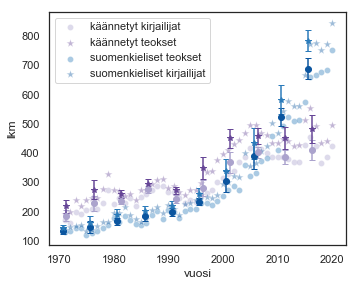

In [14]:
fig, ax = plt.subplots(figsize=(5,4))
 
my_a = 0.4

x= dffo["year"]

y1 =dffo["novel"]
y2 = dffo["author"]
y1_fi = list(dffi["novel"])
y2_fi=list(dffi["author"])

# Finnish
ax.errorbar(dffi_5["period"]-0.35, dffi_5["author_mean"], dffi_5["au_std"], linestyle='None', marker='o',color=sns.color_palette("Blues")[5],capsize=3)
ax.errorbar(dffi_5["period"]-0.35, dffi_5["novel"], dffi_5["std"], linestyle='None', marker='*',color=sns.color_palette("Blues")[4],capsize=3)


# translated
ax.errorbar(dffo_5["period"]+0.35, dffo_5["author_mean"], dffo_5["au_std"], linestyle='None', marker='o',color=sns.color_palette("PuOr_r")[1],capsize=3)
ax.errorbar(dffo_5["period"]+0.35, dffo_5["novel"], dffo_5["std"], linestyle='None', marker='*',color=sns.color_palette("PuOr_r")[0],capsize=3)


#ax.legend([], frameon=False)
ax.legend([],[], frameon=False)

ax2=sns.scatterplot(y=y2,x=x,marker="o", ax=ax, label="käännetyt kirjailijat", alpha=my_a,color=sns.color_palette("PuOr_r")[1])
ax1=sns.scatterplot(y=y1,x=x,marker="*",s=70, ax=ax, label="käännetyt teokset", alpha=my_a,color=sns.color_palette("PuOr_r")[0])



ax3=sns.scatterplot(y=y2_fi,x=x,marker="o", ax=ax, label="suomenkieliset teokset", color=sns.color_palette("Blues")[4], alpha=my_a)
ax4=sns.scatterplot(y=y1_fi,x=x, ax=ax, marker="*",s=70, label="suomenkieliset kirjailijat", color=sns.color_palette("Blues")[5], alpha=my_a)


ax.set_xlabel("vuosi")
ax.set_ylabel("lkm")
#ax.legend([])


fig.legend(handles=[ax1,ax2], frameon=False)#,ax3,ax4])

fig.tight_layout()

In [15]:
# 2010 s
dffi2010=df_fi[df_fi["year"]>2010]
dffo2010=df_fo2[df_fo2["year"]>2010]
dffi2010["novel"].nunique()/(dffi2010["novel"].nunique()+dffo2010["novel"].nunique())

0.5942572874847268

In [16]:
# 1970

dffi1970=df_fi[df_fi["year"]<1981]
dffo1970=df_fo2[df_fo2["year"]<1981]
print(1-dffi1970["novel"].nunique()/(dffi1970["novel"].nunique()+dffo1970["novel"].nunique()))
dffo1970

0.615210843373494


,year,author,nat,gender,novel,lang,publisher,pubName,genre,decade,period
0,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_8518,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,NaN,NaN,1971
1,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_23787,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Gummerus Kustannus Oy,jannitys,1970.0,1971
2,1971,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#male,http://www.btj.fi/at_1479755,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,jannitys,1970.0,1971
3,1971,http://seco.tkk.fi/saha3/u93bae653-78a3-4a7a-a...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u7d29e490-f7c3-48ca-b...,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,NaN,1971
4,1971,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p12201,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_6328,http://lexvo.org/id/iso639-3/ita,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Weilin + Göös,NaN,NaN,1971
...,...,...,...,...,...,...,...,...,...,...,...
2628,1980,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p5999,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_12221,http://lexvo.org/id/iso639-3/jpn,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,SLEY,NaN,NaN,1976
2629,1980,http://seco.tkk.fi/saha3/u8994f847-996a-48bb-9...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u8cf42d39-fa65-454d-a...,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,NaN,NaN,1976
2630,1980,http://seco.tkk.fi/saha3/u87bdeacd-81c9-46f2-9...,nonat,unk,http://seco.tkk.fi/saha3/ua88d2dac-a046-49de-9...,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,jannitys,1970.0,1976
2631,1980,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_6121,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,jannitys,1970.0,1976


## language and nationality shares

In [17]:
df5= df_fo2.groupby(["period","lang"])[["novel","author"]].nunique().reset_index()
df5

,period,lang,novel,author
0,1971,http://lexvo.org/id/iso639-3/bul,1,1
1,1971,http://lexvo.org/id/iso639-3/ces,5,4
2,1971,http://lexvo.org/id/iso639-3/dan,43,13
3,1971,http://lexvo.org/id/iso639-3/deu,41,31
4,1971,http://lexvo.org/id/iso639-3/ell,1,1
...,...,...,...,...
293,2016,http://lexvo.org/id/iso639-3/swe,477,217
294,2016,http://lexvo.org/id/iso639-3/tur,3,2
295,2016,http://lexvo.org/id/iso639-3/ukr,1,1
296,2016,http://lexvo.org/id/iso639-3/zho,14,8


In [18]:
# translations by language

per_lang=df_fo2.groupby("lang")["novel"].nunique().reset_index()
per_lang["lang"]=per_lang["lang"].apply(lambda x: x.split("/")[-1])

per_lang[per_lang["novel"]>80].sort_values(by="novel",ascending=False)

,lang,novel
12,eng,11382
50,swe,2325
10,deu,764
17,fra,726
38,nor,384
42,rus,317
9,dan,263
47,spa,249
28,ita,168
13,est,110


In [19]:
lang_labels=list(per_lang[per_lang["novel"]>80].sort_values(by="novel",ascending=False)["lang"])
lang_labels
print(lang_labels)
df5["lang"]=df5["lang"].apply(lambda x: x.split("/")[-1])

popular=df5[df5["lang"].isin(lang_labels)]
other=df5[~df5["lang"].isin(lang_labels)]

popular.sort_values(["period","author"])

['eng', 'swe', 'deu', 'fra', 'nor', 'rus', 'dan', 'spa', 'ita', 'est']


,period,lang,novel,author
20,1971,spa,4,3
6,1971,est,4,4
11,1971,ita,8,10
14,1971,nor,10,10
2,1971,dan,43,13
...,...,...,...,...
287,2016,nor,85,35
275,2016,fra,77,51
272,2016,deu,127,80
293,2016,swe,477,217


In [20]:
df5.groupby("period")["novel"].sum()

period
1971    1088
1976    1366
1981    1293
1986    1466
1991    1360
1996    1736
2001    2245
2006    2289
2011    2245
2016    2410
Name: novel, dtype: int64

In [21]:
# other sum by period

# total
allsum=df5.groupby("period")["novel"].sum().reset_index(name="all_books")

# small languages
othersum=other.groupby("period")["novel"].sum().reset_index(name="novel")
othersum["lang"]="other"

df_to_plot=pd.concat([popular[["period","novel","lang"]],othersum])
df_to_plot=df_to_plot.merge(allsum, on="period")
df_to_plot["rel"]=df_to_plot["novel"]/df_to_plot["all_books"]

In [22]:
othersum

,period,novel,lang
0,1971,36,other
1,1976,54,other
2,1981,56,other
3,1986,43,other
4,1991,56,other
5,1996,58,other
6,2001,69,other
7,2006,85,other
8,2011,77,other
9,2016,101,other


In [23]:
# prepare dataset for plotting

df_to_plot2=df_to_plot.groupby(['period', "lang"])['rel'].sum().unstack('lang')

col_order=lang_labels+["other"]#.reverse()
col_order=['eng', 'swe','nor', 'dan','deu', 'fra',  'rus',  'spa', 'ita', 'est', 'other']
#col_order#.reverse()
#col_order=['yhdysvaltalaiset', 'britit','ruotsalaiset','suomalaiset',  'saksalaiset',  'ranskalaiset', 'norjalaiset', 'venäläiset', 'tanskalaiset','kanadalaiset', 'italialaiset', 'irlantilaiset', 'espanjalaiset',  'australialaiset', 'other']
df_to_plot2=df_to_plot2[col_order]
df_to_plot2

lang,eng,swe,nor,dan,deu,fra,rus,spa,ita,est,other
period,,,,,,,,,,,
1971,0.584559,0.180147,0.009191,0.039522,0.037684,0.076287,0.024816,0.003676,0.007353,0.003676,0.033088
1976,0.580527,0.168375,0.008785,0.024158,0.062958,0.057101,0.041728,0.004392,0.007321,0.005124,0.039531
1981,0.652746,0.112142,0.013921,0.013148,0.060325,0.040990,0.037123,0.010828,0.006187,0.009281,0.043310
1986,0.723738,0.084584,0.012278,0.005457,0.041610,0.048431,0.025239,0.014325,0.009550,0.005457,0.029332
1991,0.730147,0.071324,0.014706,0.013971,0.036029,0.047059,0.013235,0.016912,0.005882,0.009559,0.041176
1996,0.715438,0.120392,0.025922,0.006912,0.037442,0.027650,0.006912,0.014977,0.006336,0.004608,0.033410
2001,0.682405,0.118931,0.028953,0.009354,0.038307,0.041871,0.012918,0.016481,0.015145,0.004900,0.030735
2006,0.667104,0.134557,0.027960,0.013106,0.034950,0.044124,0.011359,0.017475,0.010048,0.002184,0.037134
2011,0.662361,0.131849,0.020935,0.019154,0.042316,0.028953,0.020490,0.018708,0.011136,0.009800,0.034298


In [24]:
# colors



# English in blue
eng_color=sns.color_palette("husl", 12)[3]#sns.color_palette("Reds", n_colors=4)[3]
eng_color=sns.color_palette("PuOr_r", n_colors=16)[2]
#eng_color=sns.color_palette("husl", 12)[3]
swe_color=sns.color_palette("Blues_r", n_colors=4)[0]
nor_color=sns.color_palette("Blues_r", n_colors=4)[1]
dan_color=sns.color_palette("Blues_r", n_colors=4)[2]
isl_color=sns.color_palette("Blues_r", n_colors=4)[3]
european_colors=sns.color_palette("PuOr_r", n_colors=16)[9:]

eng_color=sns.color_palette("PuOr_r", n_colors=16)[3]
usa_color=sns.color_palette("PuOr_r", n_colors=16)[2]
ir_color=sns.color_palette("PuOr_r", n_colors=16)[5]
ca_color=sns.color_palette("PuOr_r", n_colors=16)[4]
au_color=sns.color_palette("PuOr_r", n_colors=16)[6]
swe_color=sns.color_palette("Blues_r", n_colors=6)[1]
nor_color=sns.color_palette("Blues_r", n_colors=6)[2]
dan_color=sns.color_palette("Blues_r", n_colors=6)[3]
isl_color=sns.color_palette("Blues_r", n_colors=6)[4]
fin_color=sns.color_palette("Blues_r", n_colors=6)[0]
european_colors=sns.color_palette("PuOr_r", n_colors=16)[8:]

# Nordic languages - shades of blue?
# European languages - shades of orange?

#NUM_COLORS = len(df_to_plot2.columns)+1
#NUM_STYLES = len(LINE_STYLES)
#clrs = sns.color_palette("PuOr_r", n_colors=8) + sns.color_palette('RdBu', n_colors=8) + sns.color_palette('Greens', n_colors=2) + sns.color_palette('pastel', n_colors=4) + sns.color_palette('husl', n_colors=NUM_COLORS-15) # a list of RGB tuples

#colorlabels = { kieli:clrs[i] for i,kieli in enumerate(kielet)}
colorlabels={"eng": eng_color ,"swe":swe_color,"dan":dan_color,"nor":nor_color}
for lan,c in zip([ 'fra','deu',  'rus',  'spa', 'ita', 'est'], european_colors):
    colorlabels[lan]=c
colorlabels["muut"] ="grey"

In [25]:
# rename other to muut for Finnish language
df_to_plot2=df_to_plot2.rename({"other":"muut"}, axis=1)
df_to_plot2

lang,eng,swe,nor,dan,deu,fra,rus,spa,ita,est,muut
period,,,,,,,,,,,
1971,0.584559,0.180147,0.009191,0.039522,0.037684,0.076287,0.024816,0.003676,0.007353,0.003676,0.033088
1976,0.580527,0.168375,0.008785,0.024158,0.062958,0.057101,0.041728,0.004392,0.007321,0.005124,0.039531
1981,0.652746,0.112142,0.013921,0.013148,0.060325,0.040990,0.037123,0.010828,0.006187,0.009281,0.043310
1986,0.723738,0.084584,0.012278,0.005457,0.041610,0.048431,0.025239,0.014325,0.009550,0.005457,0.029332
1991,0.730147,0.071324,0.014706,0.013971,0.036029,0.047059,0.013235,0.016912,0.005882,0.009559,0.041176
1996,0.715438,0.120392,0.025922,0.006912,0.037442,0.027650,0.006912,0.014977,0.006336,0.004608,0.033410
2001,0.682405,0.118931,0.028953,0.009354,0.038307,0.041871,0.012918,0.016481,0.015145,0.004900,0.030735
2006,0.667104,0.134557,0.027960,0.013106,0.034950,0.044124,0.011359,0.017475,0.010048,0.002184,0.037134
2011,0.662361,0.131849,0.020935,0.019154,0.042316,0.028953,0.020490,0.018708,0.011136,0.009800,0.034298


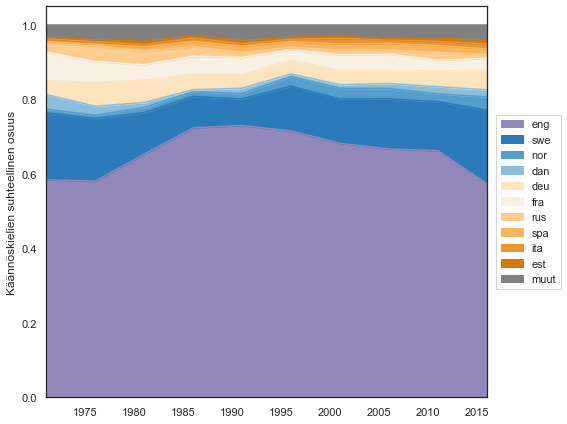

In [26]:
# plot

fig, ax= plt.subplots(1,1,figsize=(8,6))


ax=df_to_plot2.plot.area( color=colorlabels, ax=ax,legend=False)
ax.margins(0,0)

#df_to_plot2.plot.area(figsize=(12,8), color=colorlabels)

plt.legend(loc='right', bbox_to_anchor=(1.18, 
                                               0.5),
          ncol=1, fancybox=False, shadow=False)
plt.margins(0,0)
plt.xlabel(None)
plt.ylabel("Käännöskielien suhteellinen osuus")
fig.tight_layout()

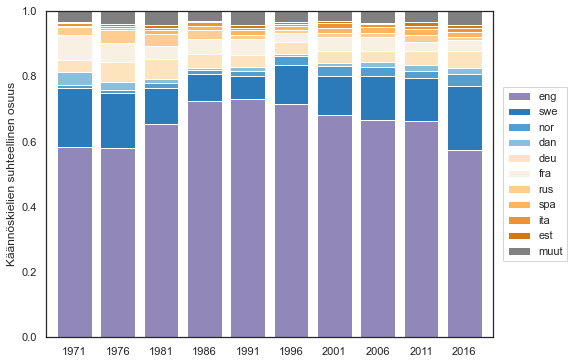

In [27]:
fig, ax= plt.subplots(1,1,figsize=(8,6))


ax=df_to_plot2.plot(kind="bar", stacked=True, color=colorlabels,ax=ax, width=0.8)
plt.legend(loc='right', bbox_to_anchor=(1.18, 
                                               0.5),
          ncol=1, fancybox=False, shadow=False)
plt.margins(0,0)
plt.xlabel(None)
plt.ylabel("Käännöskielien suhteellinen osuus")
ax.xaxis.set_tick_params(rotation=0)


In [28]:
df_to_plot_copy=df_to_plot2
colorlabels_lang=colorlabels

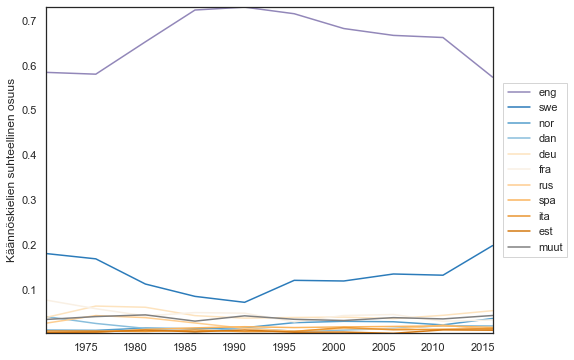

In [29]:
fig, ax= plt.subplots(1,1,figsize=(8,6))


ax=df_to_plot2.plot(kind="line",color=colorlabels,ax=ax)#, width=0.8)
plt.legend(loc='right', bbox_to_anchor=(1.18, 
                                               0.5),
          ncol=1, fancybox=False, shadow=False)
plt.margins(0,0)
plt.xlabel(None)
plt.ylabel("Käännöskielien suhteellinen osuus")
ax.xaxis.set_tick_params(rotation=0)
# doesn't really work

In [30]:
# same for nationalities

In [31]:
# query labels
Q ="""
SELECT  DISTINCT  ?nat ?nationality WHERE {

?author kaunokki:kansallisuus ?nat .
VALUES ?nat { <NAT> }

?nat skos:prefLabel ?nationality . FILTER(LANG(?nationality)="fi")


} GROUP BY  ?nat ?nationality
    

"""

#sparql = SPARQLWrapper("http://ldf.fi/kirjasampo/sparql")

nat_labels=pd.DataFrame()
for nat in df_fo2["nat"].unique():
    sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
    q=Q.replace("NAT", nat)
    sparql.setQuery(PREFIXES + q)
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
    results = sparql.query().convert()
    temp = JSON2Pandas2(results)
    nat_labels=pd.concat([nat_labels, temp])
    


In [32]:
nat_labels


,nat,nationality
0,http://www.yso.fi/onto/koko/p2224,britit
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset
0,http://www.yso.fi/onto/koko/p16897,ruotsalaiset
0,http://www.yso.fi/onto/koko/p12201,italialaiset
0,http://www.yso.fi/onto/koko/p8327,venäläiset
...,...,...
0,http://www.yso.fi/onto/koko/p75484,indonesialaiset
0,http://www.yso.fi/onto/koko/p5722,grönlantilaiset
0,http://www.yso.fi/onto/koko/p60528,Burundi
0,http://www.yso.fi/onto/koko/p51311,vironvenäläiset


In [33]:
# same for nationalities
df5n= df_fo2.groupby(["period","nat"])[["novel","author"]].nunique().reset_index()

per_nat=df_fo2.groupby("nat")["novel"].nunique().sort_values(ascending=False).reset_index()

popular = per_nat[per_nat["novel"]>=100]
popular=popular[popular["nat"]!="nonat"]
other = per_nat[per_nat["novel"]<100]
pop_df=df_fo2[df_fo2["nat"].isin(popular["nat"])]
other_df=df_fo2[~df_fo2["nat"].isin(popular["nat"])]

popular.merge(nat_labels, how="left")


,nat,novel,nationality
0,http://www.yso.fi/onto/koko/p73101,5657,yhdysvaltalaiset
1,http://www.yso.fi/onto/koko/p2224,4081,britit
2,http://www.yso.fi/onto/koko/p16897,1870,ruotsalaiset
3,http://www.yso.fi/onto/koko/p3437,655,ranskalaiset
4,http://www.yso.fi/onto/koko/p745,511,saksalaiset
5,http://www.yso.fi/onto/koko/p35259,508,suomalaiset
6,http://www.yso.fi/onto/koko/p3113,483,norjalaiset
7,http://www.yso.fi/onto/koko/p54872,375,kanadalaiset
8,http://www.yso.fi/onto/koko/p8327,307,venäläiset
9,http://www.yso.fi/onto/koko/p6292,266,tanskalaiset


In [147]:
allsum=df5n.groupby("period")["novel"].sum().reset_index(name="all_books")
othersum=other_df.groupby("period")["novel"].nunique().reset_index(name="novel")
othersum["nat"]="other"
popsum=pop_df.groupby(["period","nat"])["novel"].nunique().reset_index(name="novel")
pop_n=list(popsum.nat.unique())

In [35]:
df_to_plot=pd.concat([popsum,othersum])
df_to_plot=df_to_plot.merge(allsum, on="period")
df_to_plot["rel"]=df_to_plot["novel"]/df_to_plot["all_books"]
df_to_plot.head()

,period,nat,novel,all_books,rel
0,1971,http://www.yso.fi/onto/koko/p12201,9,1112,0.008094
1,1971,http://www.yso.fi/onto/koko/p13629,2,1112,0.001799
2,1971,http://www.yso.fi/onto/koko/p16897,158,1112,0.142086
3,1971,http://www.yso.fi/onto/koko/p2224,265,1112,0.238309
4,1971,http://www.yso.fi/onto/koko/p3113,10,1112,0.008993


In [41]:
# add labels

df_to_plot=df_to_plot.merge(nat_labels,  how="left")
df_to_plot[df_to_plot["nat"].isna()]
df_to_plot["nationality"]=df_to_plot["nationality"].fillna("muut")


In [43]:
popsum2=popsum.merge(nat_labels, how="left")

In [167]:
# colors
# color-code
# English in blue
eng_color=sns.color_palette("husl", 12)[3]#sns.color_palette("Reds", n_colors=4)[3]
eng_color=sns.color_palette("PuOr_r", n_colors=16)[3]
usa_color=sns.color_palette("PuOr_r", n_colors=16)[2]
ir_color=sns.color_palette("PuOr_r", n_colors=16)[5]
ca_color=sns.color_palette("PuOr_r", n_colors=16)[4]
au_color=sns.color_palette("PuOr_r", n_colors=16)[6]
swe_color=sns.color_palette("Blues_r", n_colors=6)[1]
nor_color=sns.color_palette("Blues_r", n_colors=6)[2]
dan_color=sns.color_palette("Blues_r", n_colors=6)[3]
isl_color=sns.color_palette("Blues_r", n_colors=6)[4]
fin_color=sns.color_palette("Blues_r", n_colors=6)[0]
european_colors=sns.color_palette("PuOr_r", n_colors=16)[8:]

# Nordic languages - shades of blue?
# European languages - shades of orange?

#NUM_COLORS = len(df_to_plot2.columns)+1
#NUM_STYLES = len(LINE_STYLES)
#clrs = sns.color_palette("PuOr_r", n_colors=8) + sns.color_palette('RdBu', n_colors=8) + sns.color_palette('Greens', n_colors=2) + sns.color_palette('pastel', n_colors=4) + sns.color_palette('husl', n_colors=NUM_COLORS-15) # a list of RGB tuples

#colorlabels = { kieli:clrs[i] for i,kieli in enumerate(kielet)}
colorlabels={"britit": eng_color,"yhdysvaltalaiset":usa_color ,"kanadalaiset":ca_color,"irlantilaiset":ir_color,"australialaiset":au_color,"ruotsalaiset":swe_color,"tanskalaiset":dan_color,"norjalaiset":nor_color, "suomalaiset":fin_color}
for lan,c in zip(['ranskalaiset', 'saksalaiset',  'venäläiset',  'itävaltalaiset',"italialaiset", 'espanjalaiset', 'virolaiset'], european_colors):
    colorlabels[lan]=c
colorlabels["muut"] ="grey"

In [45]:
df_to_plot2=df_to_plot.groupby(['period', "nationality"])['rel'].sum().unstack('nationality')
#

col_order=list(popsum2.sort_values("novel", ascending=False).nationality.unique())+["muut"]
col_order=["yhdysvaltalaiset","britit","kanadalaiset","irlantilaiset","australialaiset","suomalaiset","ruotsalaiset","norjalaiset","tanskalaiset",  'ranskalaiset','saksalaiset',"venäläiset",'itävaltalaiset' ,'italialaiset',
 'espanjalaiset', 'virolaiset',"muut"]
#col_order=['yhdysvaltalaiset', 'britit','ruotsalaiset','suomalaiset',  'saksalaiset',  'ranskalaiset', 'norjalaiset', 'venäläiset', 'tanskalaiset','kanadalaiset', 'italialaiset', 'irlantilaiset', 'espanjalaiset',  'australialaiset', 'other']
df_to_plot2=df_to_plot2[col_order]
df_to_plot2

nationality,yhdysvaltalaiset,britit,kanadalaiset,irlantilaiset,australialaiset,suomalaiset,ruotsalaiset,norjalaiset,tanskalaiset,ranskalaiset,saksalaiset,venäläiset,itävaltalaiset,italialaiset,espanjalaiset,virolaiset,muut
period,,,,,,,,,,,,,,,,,
1971,0.234712,0.238309,0.010791,0.008993,0.018885,0.030576,0.142086,0.008993,0.038669,0.061151,0.029676,0.022482,0.001799,0.008094,0.001799,0.003597,0.138489
1976,0.226657,0.237349,0.015681,0.002138,0.013542,0.027798,0.135424,0.009266,0.019957,0.049893,0.042053,0.037063,0.011404,0.007128,0.000713,0.004989,0.157520
1981,0.273134,0.255224,0.009701,0.002985,0.017910,0.030597,0.076866,0.013433,0.010448,0.035075,0.040299,0.035821,0.011940,0.005970,0.001493,0.008955,0.167910
1986,0.344737,0.219079,0.020395,0.005921,0.013158,0.025658,0.058553,0.011184,0.005263,0.042105,0.021053,0.021053,0.011842,0.009211,0.004605,0.005263,0.178289
1991,0.395775,0.222535,0.014789,0.004930,0.004930,0.019014,0.050000,0.025352,0.013380,0.041549,0.023944,0.012676,0.009155,0.006338,0.007042,0.009859,0.137324
1996,0.389894,0.188830,0.018617,0.009574,0.003191,0.018085,0.094149,0.066489,0.006383,0.025000,0.019681,0.006383,0.009043,0.006383,0.007447,0.004787,0.125000
2001,0.342648,0.221840,0.027515,0.021066,0.012038,0.024936,0.092003,0.027945,0.012898,0.037833,0.021066,0.013758,0.015907,0.010748,0.008169,0.004729,0.104471
2006,0.319415,0.233820,0.025052,0.025470,0.011273,0.030898,0.100209,0.027557,0.012944,0.039666,0.021294,0.011273,0.008768,0.010021,0.012944,0.001670,0.105637
2011,0.330213,0.221277,0.027660,0.016170,0.015319,0.028936,0.105532,0.020851,0.018298,0.026809,0.026809,0.019149,0.007660,0.010638,0.013191,0.008936,0.100426


In [46]:
# names with country codes
ndict={"yhdysvaltalaiset":"US","britit":"UK","kanadalaiset":"CA","irlantilaiset":"IR","australialaiset":"AU","suomalaiset":"FI","ruotsalaiset":"SE","norjalaiset":"NO","tanskalaiset":"DK",  'ranskalaiset':"FR",'saksalaiset':"DE","venäläiset":"RU",'itävaltalaiset':"AT" ,'italialaiset':"IT",
 'espanjalaiset':"ES", 'virolaiset':"EE","other":"muut"}

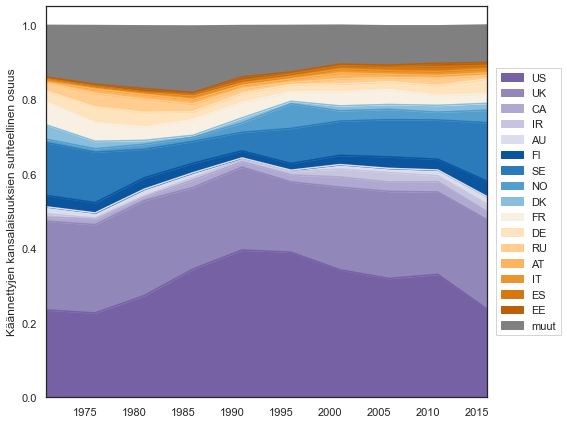

In [47]:
fig, ax= plt.subplots(1,1,figsize=(8,6))


ax=df_to_plot2.plot.area( color=colorlabels, ax=ax,legend=False)
ax.margins(0,0)
plt.xlabel(None)
plt.ylabel("Käännettyjen kansalaisuuksien suhteellinen osuus")
h, l = ax.get_legend_handles_labels()
plt.legend(handles=h,labels=list(ndict.values()),#loc='right', bbox_to_anchor=(1.11, 
                                               #0.5),
           loc='right', bbox_to_anchor=(1.18, 
                                               0.5),
          ncol=1, fancybox=False, shadow=False)

fig.tight_layout()

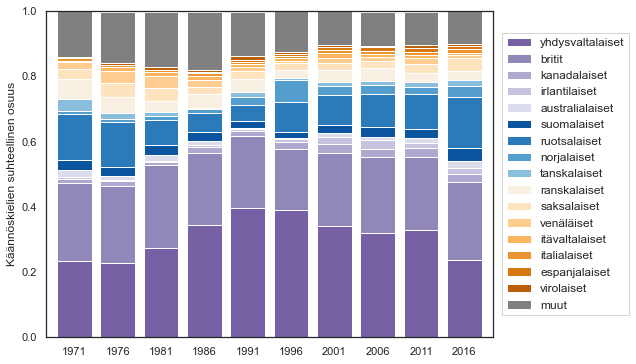

In [49]:
fig, ax= plt.subplots(1,1,figsize=(8,6))


ax=df_to_plot2.plot(kind="bar", stacked=True, color=colorlabels,ax=ax, width=0.8)
plt.legend(loc='right', bbox_to_anchor=(1.32, 
                                               0.5),
          ncol=1, fancybox=False, shadow=False,prop={'size': 12})


plt.margins(0,0)
plt.xlabel(None)
plt.ylabel("Käännöskielien suhteellinen osuus")
ax.xaxis.set_tick_params(rotation=0)

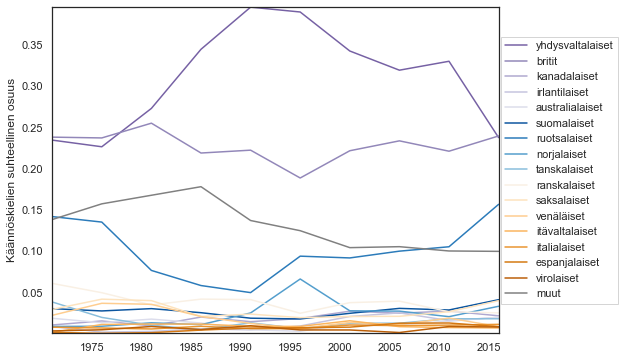

In [50]:
fig, ax= plt.subplots(1,1,figsize=(8,6))


ax=df_to_plot2.plot(kind="line",color=colorlabels,ax=ax)#, width=0.8)
plt.legend(loc='right', bbox_to_anchor=(1.28, 
                                               0.5),
          ncol=1, fancybox=False, shadow=False)
plt.margins(0,0)
plt.xlabel(None)
plt.ylabel("Käännöskielien suhteellinen osuus")
ax.xaxis.set_tick_params(rotation=0)
# doesn't really work

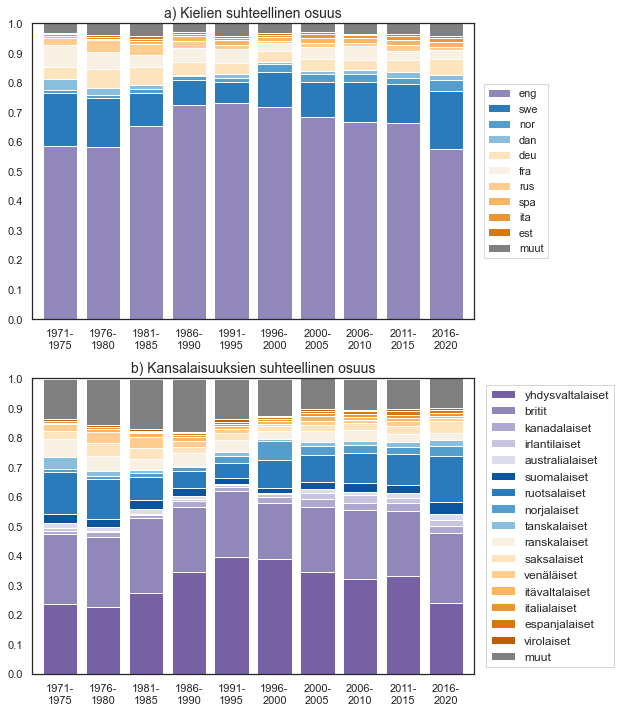

In [51]:
# both languages and nationalities

fig, ax= plt.subplots(2,1,figsize=(9,10))

# lang
plt.yticks(np.arange(0, 1.1, step=0.1))

ax0=df_to_plot_copy.plot(kind="bar", stacked=True, color=colorlabels_lang,ax=ax[0], width=0.8)
lgd1=ax[0].legend(loc='right', bbox_to_anchor=(1.18, 
                                               0.5),
          ncol=1, fancybox=False, shadow=False)
ax[0].margins(0,0)
plt.xlabel(None)
#plt.ylabel("Käännöskielien suhteellinen osuus")
ax[0].xaxis.set_tick_params(rotation=0)
plt.yticks(np.arange(0, 1.1, step=0.1))

# nationality
ax[1]=df_to_plot2.plot(kind="bar", stacked=True, color=colorlabels,ax=ax[1], width=0.8)
lgd=ax[1].legend(loc='right', bbox_to_anchor=(1.33, 
                                               0.5),
          ncol=1, fancybox=False, shadow=False,prop={'size': 12})


plt.margins(0,0)
plt.xlabel(None)
#plt.ylabel("Kansalaisuuksien suhteellinen osuus", fontsize=14)
ax[1].xaxis.set_tick_params(rotation=0)
plt.title("b) Kansalaisuuksien suhteellinen osuus", fontsize=14)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(range(10),["1971-\n1975","1976-\n1980","1981-\n1985","1986-\n1990","1991-\n1995","1996-\n2000","2000-\n2005","2006-\n2010","2011-\n2015","2016-\n2020"])
#locs, labels = plt.xticks()
# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(range(10),["1971-\n1975","1976-\n1980","1981-\n1985","1986-\n1990","1991-\n1995","1996-\n2000","2000-\n2005","2006-\n2010","2011-\n2015","2016-\n2020"])
plt.xlabel(None)
#plt.ylabel("Kielien suhteellinen osuus", fontsize=14)
plt.title("a) Kielien suhteellinen osuus", fontsize=14)
fig.tight_layout()
#lgd=plt.get_legend()
#fig.savefig('../../output/lang_nat_bars_titled.png', bbox_extra_artists=(lgd,lgd1), bbox_inches='tight')

## gender biases

In [52]:

df_f= df_fo2[df_fo2["gender"].str.contains("female")]
df_m= df_fo2[df_fo2["gender"].str.contains("#male")]

df5_gender=df_fo2.groupby(["period","gender","lang"])[["novel","author"]].nunique().reset_index()
df5_gender["lang"]= df5_gender["lang"].apply(lambda x: x.split("/")[-1])

In [53]:


print(lang_labels)


['eng', 'swe', 'deu', 'fra', 'nor', 'rus', 'dan', 'spa', 'ita', 'est']


In [54]:
# female languages
df5_f= df_f.groupby(["period","lang"])[["novel","author"]].nunique().reset_index()

per_nat_f=df_f.groupby("lang")["novel"].nunique().sort_values(ascending=False).reset_index()

#popular = per_nat_f[per_nat_f["novel"]>=100]
#popular_f=popular_f[popular_f["lang"]!="unk"]
#other_f = per_nat_f[per_nat_f["novel"]<100]
#pop_df_f=df5_gender[df5_gender["lang"].isin(lang_labels)]
#other_df_f=df5_gender[~df5_gender["lang"].isin(lang_labels)]
#popular_f
popular =df5_gender[df5_gender["lang"].isin(lang_labels)]
other =df5_gender[~df5_gender["lang"].isin(lang_labels)]
popular.sort_values(["period","author"])

,period,gender,lang,novel,author
3,1971,http://www.yso.fi/onto/kaunokki#female,est,1,1
39,1971,unk,fra,4,1
40,1971,unk,nor,1,1
0,1971,http://www.yso.fi/onto/kaunokki#female,dan,6,2
37,1971,unk,deu,2,2
...,...,...,...,...,...
439,2016,http://www.yso.fi/onto/kaunokki#female,deu,79,46
482,2016,http://www.yso.fi/onto/kaunokki#male,swe,173,93
455,2016,http://www.yso.fi/onto/kaunokki#female,swe,311,123
464,2016,http://www.yso.fi/onto/kaunokki#male,eng,528,271


In [55]:
# male languages
df5_m= df_m.groupby(["period","lang"])[["novel","author"]].nunique().reset_index()

per_nat_m=df_m.groupby("lang")["novel"].nunique().sort_values(ascending=False).reset_index()

##popular_m = per_nat_m[per_nat_m["novel"]>=100]
#p#opular_m=popular_m[popular_m["lang"]!="unk"]
#o#ther_m = per_nat_m[per_nat_m["novel"]<100]
pop_df_m=df_m[df_m["lang"].isin(lang_labels)]
other_df_m=df_m[~df_m["lang"].isin(lang_labels)]
df_fo2["lang"]=df_fo2["lang"].apply(lambda x: x.split("/")[-1])

In [154]:
# nationalities
#print(nat_labels)
#allsum=df5n.groupby("period")["novel"].sum().reset_index(name="all_books")
othersumn=df_fo2[~df_fo2["nat"].isin(pop_n)].groupby(["period","gender"])["novel"].nunique().reset_index(name="novel")
othersumn["nat"]="muut"
othersumn.tail()

,period,gender,novel,nat
25,2011,http://www.yso.fi/onto/kaunokki#male,122,muut
26,2011,unk,3,muut
27,2016,http://www.yso.fi/onto/kaunokki#female,121,muut
28,2016,http://www.yso.fi/onto/kaunokki#male,122,muut
29,2016,unk,8,muut


In [152]:
df5_gendern=df_fo2.groupby(["period","gender","nat"])[["novel","author"]].nunique().reset_index()
popularn =df5_gendern[df5_gendern["nat"].isin(pop_n)]
othern =df5_gendern[~df5_gendern["nat"].isin(pop_n)]

In [156]:
allsum=df_fo2.groupby(["period","gender"])["novel"].nunique().reset_index(name="novel")
othersum=df_fo2[~df_fo2["lang"].isin(lang_labels)].groupby(["period","gender"])["novel"].nunique().reset_index(name="novel")
othersum["lang"]="muut"
othersum

,period,gender,novel,lang
0,1971,http://www.yso.fi/onto/kaunokki#female,6,muut
1,1971,http://www.yso.fi/onto/kaunokki#male,30,muut
2,1976,http://www.yso.fi/onto/kaunokki#female,8,muut
3,1976,http://www.yso.fi/onto/kaunokki#male,44,muut
4,1976,unk,2,muut
5,1981,http://www.yso.fi/onto/kaunokki#female,8,muut
6,1981,http://www.yso.fi/onto/kaunokki#male,47,muut
7,1981,unk,1,muut
8,1986,http://www.yso.fi/onto/kaunokki#female,9,muut
9,1986,http://www.yso.fi/onto/kaunokki#male,33,muut


In [57]:
df_to_plot=pd.concat([popular[["period","gender","novel","lang"]],othersum])
df_to_plot=df_to_plot.merge(allsum, on=["period","gender"], suffixes=["","_all"])
df_to_plot["rel"]=df_to_plot["novel"]/df_to_plot["novel_all"]

In [157]:
df_to_plotn=pd.concat([popularn[["period","gender","novel","nat"]],othersumn])
df_to_plotn=df_to_plotn.merge(allsum, on=["period","gender"], suffixes=["","_all"])
df_to_plotn["rel"]=df_to_plotn["novel"]/df_to_plotn["novel_all"]

In [58]:
df_to_plot["lang"]=df_to_plot["lang"].apply(lambda x: x.split("/")[-1])
df_to_plot

,period,gender,novel,lang,novel_all,rel
0,1971,http://www.yso.fi/onto/kaunokki#female,6,dan,347,0.017291
1,1971,http://www.yso.fi/onto/kaunokki#female,6,deu,347,0.017291
2,1971,http://www.yso.fi/onto/kaunokki#female,210,eng,347,0.605187
3,1971,http://www.yso.fi/onto/kaunokki#female,1,est,347,0.002882
4,1971,http://www.yso.fi/onto/kaunokki#female,21,fra,347,0.060519
...,...,...,...,...,...,...
254,2016,http://www.yso.fi/onto/kaunokki#male,69,muut,1022,0.067515
255,2016,unk,2,deu,23,0.086957
256,2016,unk,15,eng,23,0.652174
257,2016,unk,1,spa,23,0.043478


In [59]:
df_to_plot2=df_to_plot.groupby(['period', "lang","gender"])['rel'].sum().unstack('lang')
#
#print(len( sns.color_palette('Set2')))
col_order=lang_labels+["muut"]#.reverse()
col_order=['eng', 'swe','nor', 'dan','deu', 'fra',  'rus',  'spa', 'ita', 'est', 'muut']
#col_order#.reverse()
#col_order=['yhdysvaltalaiset', 'britit','ruotsalaiset','suomalaiset',  'saksalaiset',  'ranskalaiset', 'norjalaiset', 'venäläiset', 'tanskalaiset','kanadalaiset', 'italialaiset', 'irlantilaiset', 'espanjalaiset',  'australialaiset', 'other']
df_to_plot2=df_to_plot2[col_order]
df_to_plot2

lang                                                eng       swe       nor  \
period gender                                                                 
1971   http://www.yso.fi/onto/kaunokki#female  0.605187  0.270893  0.008646   
       http://www.yso.fi/onto/kaunokki#male    0.584795  0.146199  0.008772   
       unk                                     0.444444  0.079365  0.015873   
1976   http://www.yso.fi/onto/kaunokki#female  0.603104  0.299335  0.002217   
       http://www.yso.fi/onto/kaunokki#male    0.555300  0.110599  0.012673   
       unk                                     0.775862  0.068966       NaN   
1981   http://www.yso.fi/onto/kaunokki#female  0.729339  0.146694  0.016529   
       http://www.yso.fi/onto/kaunokki#male    0.595579  0.096229  0.013004   
       unk                                     0.844444       NaN       NaN   
1986   http://www.yso.fi/onto/kaunokki#female  0.736207  0.110345  0.010345   
       http://www.yso.fi/onto/kaunokki#male    0.704142  0.071006  0.014201   
       unk                                     0.918367       NaN       NaN   
1991   http://www.yso.fi/onto/kaunokki#female  0.788043  0.070652  0.019928   
       http://www.yso.fi/onto/kaunokki#male    0.680958  0.074401  0.010088   
       unk                                     0.968750       NaN  0.031250   
1996   http://www.yso.fi/onto/kaunokki#female  0.710327  0.168766  0.037783   
       http://www.yso.fi/onto/kaunokki#male    0.718717  0.081283  0.016043   
       unk                                     0.955556       NaN       NaN   
2001   http://www.yso.fi/onto/kaunokki#female  0.756585  0.107175  0.029973   
       http://www.yso.fi/onto/kaunokki#male    0.626527  0.129145  0.027923   
       unk                                     0.454545  0.030303       NaN   
2006   http://www.yso.fi/onto/kaunokki#female  0.730317  0.135747  0.023529   
       http://www.yso.fi/onto/kaunokki#male    0.609983  0.133672  0.031303   
       unk                                     0.838710  0.064516  0.032258   
2011   http://www.yso.fi/onto/kaunokki#female  0.738037  0.136253  0.010543   
       http://www.yso.fi/onto/kaunokki#male    0.569608  0.128431  0.035294   
       unk                                     0.500000  0.250000       NaN   
2016   http://www.yso.fi/onto/kaunokki#female  0.611351  0.223420  0.019397   
       http://www.yso.fi/onto/kaunokki#male    0.516634  0.169276  0.056751   
       unk                                     0.652174  0.217391       NaN   

lang                                                dan       deu       fra  \
period gender                                                                 
1971   http://www.yso.fi/onto/kaunokki#female  0.017291  0.017291  0.060519   
       http://www.yso.fi/onto/kaunokki#male    0.020468  0.048246  0.086257   
       unk                                     0.365079  0.031746  0.063492   
1976   http://www.yso.fi/onto/kaunokki#female  0.006652  0.037694  0.017738   
       http://www.yso.fi/onto/kaunokki#male    0.031106  0.076037  0.079493   
       unk                                     0.051724  0.051724  0.017241   
1981   http://www.yso.fi/onto/kaunokki#female  0.008264  0.030992  0.035124   
       http://www.yso.fi/onto/kaunokki#male    0.016905  0.076723  0.044213   
       unk                                          NaN  0.088889  0.044444   
1986   http://www.yso.fi/onto/kaunokki#female  0.003448  0.051724  0.051724   
       http://www.yso.fi/onto/kaunokki#male    0.007101  0.036686  0.047337   
       unk                                          NaN       NaN  0.020408   
1991   http://www.yso.fi/onto/kaunokki#female  0.007246  0.047101  0.025362   
       http://www.yso.fi/onto/kaunokki#male    0.018916  0.032787  0.063052   
       unk                                          NaN       NaN       NaN   
1996   http://www.yso.fi/onto/kaunokki#female  0.001259  0.031486  0.017632   
       http://www.yso.fi/onto/kaunokki#male    0.

In [163]:
df_to_plotn=df_to_plotn.merge(nat_labels, how="left")#.fillna("muut")
df_to_plotn["nationality"]=df_to_plotn["nationality"].fillna("muut")

In [186]:
# nationalities

df_to_plot2_ng=df_to_plotn.groupby(['period', "nationality","gender"])['rel'].sum().unstack('nationality')
#

col_order=list(popsum2.sort_values("novel", ascending=False).nationality.unique())+["muut"]
col_order=["yhdysvaltalaiset","britit","kanadalaiset","irlantilaiset","australialaiset","suomalaiset","ruotsalaiset","norjalaiset","tanskalaiset",  'ranskalaiset','saksalaiset',"venäläiset",'itävaltalaiset' ,'italialaiset',
 'espanjalaiset', 'virolaiset',"muut"]
#col_order=['yhdysvaltalaiset', 'britit','ruotsalaiset','suomalaiset',  'saksalaiset',  'ranskalaiset', 'norjalaiset', 'venäläiset', 'tanskalaiset','kanadalaiset', 'italialaiset', 'irlantilaiset', 'espanjalaiset',  'australialaiset', 'other']
df_to_plot2_ng=df_to_plot2_ng[col_order]
df_to_plot2_ng

nationality                                    yhdysvaltalaiset    britit  \
period gender                                                               
1971   http://www.yso.fi/onto/kaunokki#female          0.149856  0.394813   
       http://www.yso.fi/onto/kaunokki#male            0.288012  0.185673   
       unk                                             0.190476  0.031746   
1976   http://www.yso.fi/onto/kaunokki#female          0.159645  0.361419   
       http://www.yso.fi/onto/kaunokki#male            0.282258  0.193548   
       unk                                             0.034483  0.068966   
1981   http://www.yso.fi/onto/kaunokki#female          0.301653  0.326446   
       http://www.yso.fi/onto/kaunokki#male            0.283485  0.235371   
       unk                                             0.133333  0.066667   
1986   http://www.yso.fi/onto/kaunokki#female          0.370690  0.215517   
       http://www.yso.fi/onto/kaunokki#male            0.357396  0.244970   
       unk                                             0.224490  0.040816   
1991   http://www.yso.fi/onto/kaunokki#female          0.438406  0.248188   
       http://www.yso.fi/onto/kaunokki#male            0.413619  0.218159   
       unk                                             0.156250  0.187500   
1996   http://www.yso.fi/onto/kaunokki#female          0.445844  0.190176   
       http://www.yso.fi/onto/kaunokki#male            0.427807  0.206417   
       unk                                             0.222222  0.311111   
2001   http://www.yso.fi/onto/kaunokki#female          0.412352  0.247956   
       http://www.yso.fi/onto/kaunokki#male            0.321990  0.205934   
       unk                                             0.212121  0.212121   
2006   http://www.yso.fi/onto/kaunokki#female          0.366516  0.264253   
       http://www.yso.fi/onto/kaunokki#male            0.313029  0.225042   
       unk                                             0.322581  0.129032   
2011   http://www.yso.fi/onto/kaunokki#female          0.387672  0.240876   
       http://www.yso.fi/onto/kaunokki#male            0.300980  0.218627   
       unk                                                  NaN  0.062500   
2016   http://www.yso.fi/onto/kaunokki#female          0.270833  0.239943   
       http://www.yso.fi/onto/kaunokki#male            0.214286  0.264188   
       unk                                             0.130435  0.217391   

nationality                                    kanadalaiset  irlantilaiset  \
period gender                                                                
1971   http://www.yso.fi/onto/kaunokki#female      0.005764       0.011527   
       http://www.yso.fi/onto/kaunokki#male        0.014620       0.008772   
       unk                                              NaN            NaN   
1976   http://www.yso.fi/onto/kaunokki#female      0.011086       0.004435   
       http://www.yso.fi/onto/kaunokki#male        0.008065       0.001152   
       unk                                         0.172414            NaN   
1981   http://www.yso.fi/onto/kaunokki#female      0.014463       0.006198   
       http://www.yso.fi/onto/kaunokki#male        0.005202       0.001300   
       unk                                         0.044444            NaN   
1986   http://www.yso.fi/onto/kaunokki#female      0.025862       0.006897   
       http://www.yso.fi/onto/kaunokki#male        0.018935       0.005917   
       unk                                              NaN            NaN   
1991   http://www.yso.fi/onto/kaunokki#female      0.028986       0.007246   
       http://www.yso.fi/onto/kaunokki#male        0.006305       0.003783   
       unk                                              NaN            NaN   
1996   http://www.yso.fi/onto/kaunokki#female      0.025189       0.007557   
       http://www.yso.fi/onto/kaunokki#male        0.016043       0.012834   
       unk                                           

In [173]:
# English in blue
eng_color=sns.color_palette("husl", 12)[3]#sns.color_palette("Reds", n_colors=4)[3]
eng_color=sns.color_palette("PuOr_r", n_colors=16)[2]
#eng_color=sns.color_palette("husl", 12)[3]
swe_color=sns.color_palette("Blues_r", n_colors=4)[0]
nor_color=sns.color_palette("Blues_r", n_colors=4)[1]
dan_color=sns.color_palette("Blues_r", n_colors=4)[2]
isl_color=sns.color_palette("Blues_r", n_colors=4)[3]
european_colors=sns.color_palette("PuOr_r", n_colors=16)[9:]

eng_color=sns.color_palette("PuOr_r", n_colors=16)[3]
usa_color=sns.color_palette("PuOr_r", n_colors=16)[2]
ir_color=sns.color_palette("PuOr_r", n_colors=16)[5]
ca_color=sns.color_palette("PuOr_r", n_colors=16)[4]
au_color=sns.color_palette("PuOr_r", n_colors=16)[6]
swe_color=sns.color_palette("Blues_r", n_colors=6)[1]
nor_color=sns.color_palette("Blues_r", n_colors=6)[2]
dan_color=sns.color_palette("Blues_r", n_colors=6)[3]
isl_color=sns.color_palette("Blues_r", n_colors=6)[4]
fin_color=sns.color_palette("Blues_r", n_colors=6)[0]
european_colors=sns.color_palette("PuOr_r", n_colors=16)[8:]

# Nordic languages - shades of blue?
# European languages - shades of orange?

#NUM_COLORS = len(df_to_plot2.columns)+1
#NUM_STYLES = len(LINE_STYLES)
#clrs = sns.color_palette("PuOr_r", n_colors=8) + sns.color_palette('RdBu', n_colors=8) + sns.color_palette('Greens', n_colors=2) + sns.color_palette('pastel', n_colors=4) + sns.color_palette('husl', n_colors=NUM_COLORS-15) # a list of RGB tuples

#colorlabels = { kieli:clrs[i] for i,kieli in enumerate(kielet)}
colorlabels={"eng": eng_color ,"swe":swe_color,"dan":dan_color,"nor":nor_color}
for lan,c in zip([ 'fra','deu',  'rus',  'spa', 'ita', 'est'], european_colors):
    colorlabels[lan]=c
colorlabels["muut"] ="grey"

In [174]:
# nationalities

eng_color=sns.color_palette("husl", 12)[3]#sns.color_palette("Reds", n_colors=4)[3]
eng_color=sns.color_palette("PuOr_r", n_colors=16)[3]
usa_color=sns.color_palette("PuOr_r", n_colors=16)[2]
ir_color=sns.color_palette("PuOr_r", n_colors=16)[5]
ca_color=sns.color_palette("PuOr_r", n_colors=16)[4]
au_color=sns.color_palette("PuOr_r", n_colors=16)[6]
swe_color=sns.color_palette("Blues_r", n_colors=6)[1]
nor_color=sns.color_palette("Blues_r", n_colors=6)[2]
dan_color=sns.color_palette("Blues_r", n_colors=6)[3]
isl_color=sns.color_palette("Blues_r", n_colors=6)[4]
fin_color=sns.color_palette("Blues_r", n_colors=6)[0]
european_colors=sns.color_palette("PuOr_r", n_colors=16)[8:]

# Nordic languages - shades of blue?
# European languages - shades of orange?

#NUM_COLORS = len(df_to_plot2.columns)+1
#NUM_STYLES = len(LINE_STYLES)
#clrs = sns.color_palette("PuOr_r", n_colors=8) + sns.color_palette('RdBu', n_colors=8) + sns.color_palette('Greens', n_colors=2) + sns.color_palette('pastel', n_colors=4) + sns.color_palette('husl', n_colors=NUM_COLORS-15) # a list of RGB tuples

#colorlabels = { kieli:clrs[i] for i,kieli in enumerate(kielet)}
colorlabels_n={"britit": eng_color,"yhdysvaltalaiset":usa_color ,"kanadalaiset":ca_color,"irlantilaiset":ir_color,"australialaiset":au_color,"ruotsalaiset":swe_color,"tanskalaiset":dan_color,"norjalaiset":nor_color, "suomalaiset":fin_color}
for lan,c in zip(['ranskalaiset', 'saksalaiset',  'venäläiset',  'itävaltalaiset',"italialaiset", 'espanjalaiset', 'virolaiset'], european_colors):
    colorlabels_n[lan]=c
colorlabels_n["muut"] ="grey"

In [61]:
df_to_plot2=df_to_plot2.rename({"other":"muut"}, axis=1)

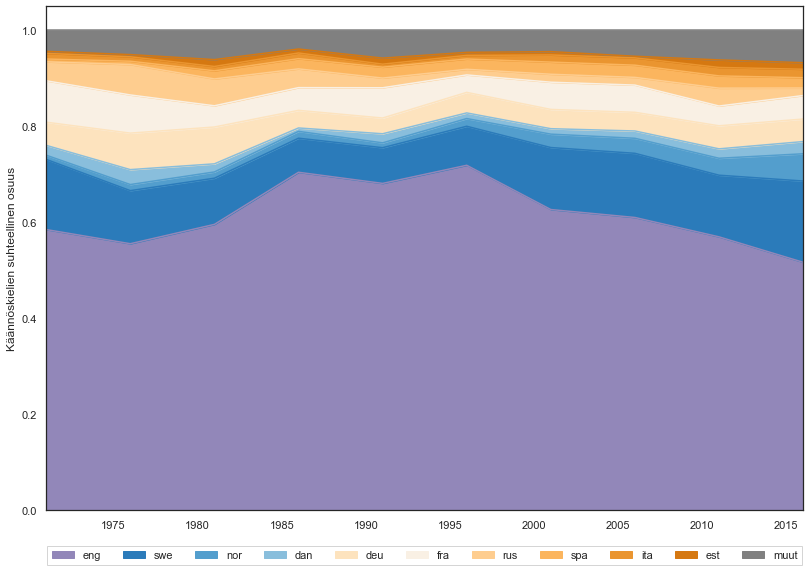

In [195]:
df_to_plot3=df_to_plot2.reset_index()
df_to_plot3m=df_to_plot3[df_to_plot3["gender"].str.contains("#male")]
df_to_plot3m.set_index(["period","gender"])

df_to_plot3f=df_to_plot3[df_to_plot3["gender"].str.contains("#female")]
df_to_plot3f.set_index(["period","gender"])

df_to_plot3m.set_index(["period"]).drop("gender", axis=1).plot.area(figsize=(12,8), color=colorlabels)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 
                                               -0.06),
          ncol=11, fancybox=False, shadow=False)
plt.margins(0,0)
plt.xlabel(None)
plt.ylabel("Käännöskielien suhteellinen osuus")
plt.tight_layout()

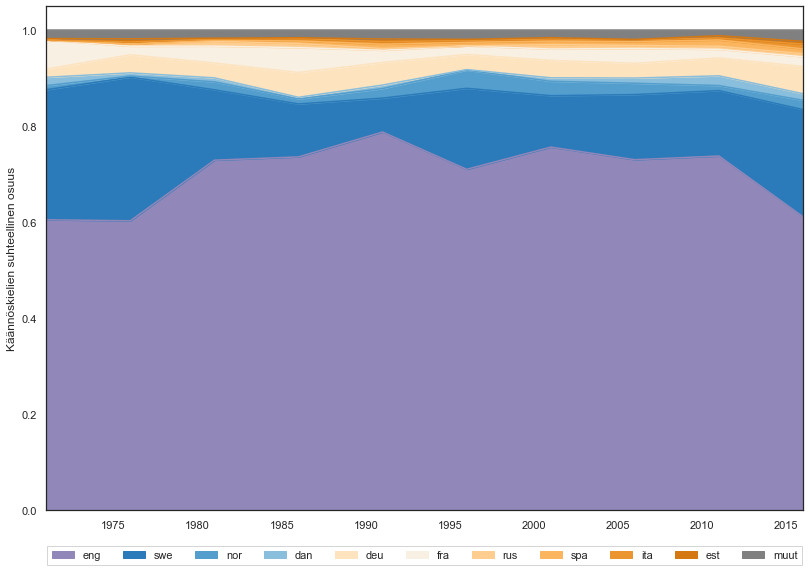

In [196]:
df_to_plot3=df_to_plot2.reset_index()
df_to_plot3=df_to_plot3[df_to_plot3["gender"].str.contains("#female")]
df_to_plot3.set_index(["period","gender"])
df_to_plot3.set_index(["period"]).drop("gender", axis=1).plot.area(figsize=(12,8), color=colorlabels)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 
                                               -0.06),
          ncol=11, fancybox=False, shadow=False)
plt.margins(0,0)
plt.xlabel(None)
plt.ylabel("Käännöskielien suhteellinen osuus")
plt.tight_layout()

In [ ]:
# 2*2 plot

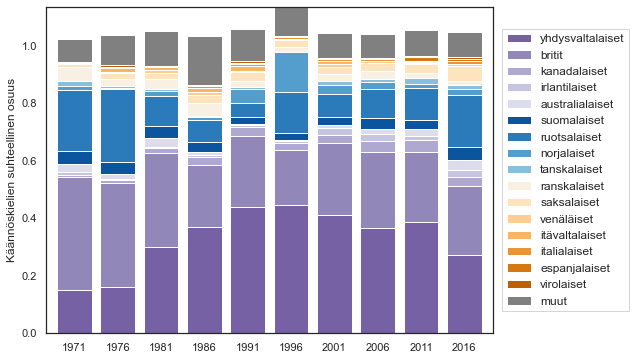

In [193]:
# nationalities, male

fig, ax= plt.subplots(1,1,figsize=(8,6))
df_to_plot3_nm=df_to_plot2_ng.reset_index()[df_to_plot2_ng.reset_index()["gender"].str.contains("#male")]
df_to_plot3_nm.set_index(["period","gender"])


df_to_plot3_nf=df_to_plot2_ng.reset_index()[df_to_plot2_ng.reset_index()["gender"].str.contains("#female")]
df_to_plot3_nf.set_index(["period","gender"])

ax=df_to_plot3_nf.set_index(["period"]).drop("gender", axis=1).plot(kind="bar", stacked=True, color=colorlabels_n,ax=ax, width=0.8)
plt.legend(loc='right', bbox_to_anchor=(1.32, 
                                               0.5),
          ncol=1, fancybox=False, shadow=False,prop={'size': 12})


plt.margins(0,0)
plt.xlabel(None)
plt.ylabel("Käännöskielien suhteellinen osuus")
ax.xaxis.set_tick_params(rotation=0)

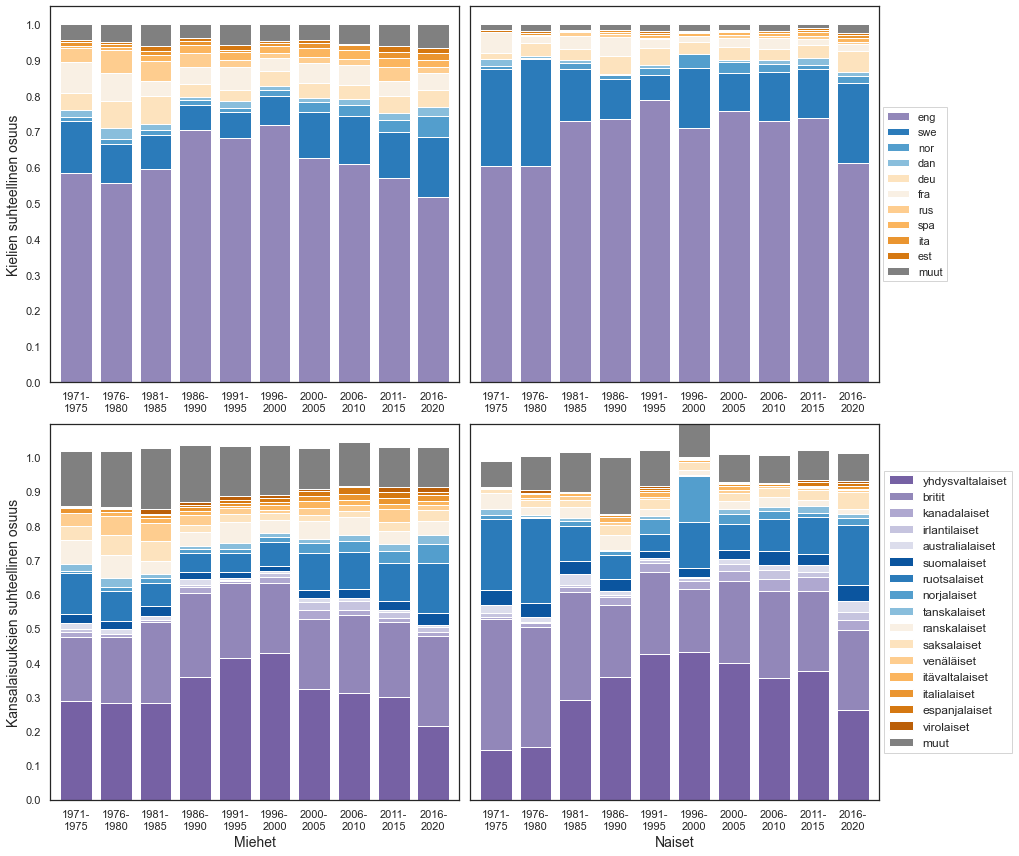

In [230]:
fig, ax= plt.subplots(2,2,figsize=(14,12))


ax0=df_to_plot3m.set_index(["period"]).drop("gender", axis=1).plot(kind="bar", stacked=True, color=colorlabels,ax=ax[0][0], width=0.8)
ax1=df_to_plot3f.set_index(["period"]).drop("gender", axis=1).plot(kind="bar", stacked=True, color=colorlabels,ax=ax[0][1], width=0.8)

ax0.legend("", frameon=False)
lgd1=ax1.legend(loc='right', bbox_to_anchor=(1.18, 
                                               0.5),
          ncol=1, fancybox=False, shadow=False)

ax2=df_to_plot3_nm.set_index(["period"]).drop("gender", axis=1).plot(kind="bar", stacked=True, color=colorlabels_n,ax=ax[1][0], width=0.8)
ax3=df_to_plot3_nf.set_index(["period"]).drop("gender", axis=1).plot(kind="bar", stacked=True, color=colorlabels_n,ax=ax[1][1], width=0.8)
lgd3=ax3.legend(loc='right', bbox_to_anchor=(1.34, 
                                               0.5),
          ncol=1, fancybox=False, shadow=False,prop={'size': 12})

ax2.legend("", frameon=False)
plt.margins(0,0)
plt.xlabel(None)
#plt.ylabel("Käännöskielien suhteellinen osuus")
ax2.xaxis.set_tick_params(rotation=0)



plt.margins(0,0)
plt.xlabel(None)
#ax2.ylabel("Käännöskielien suhteellinen osuus")
ax0.xaxis.set_tick_params(rotation=0)
ax1.xaxis.set_tick_params(rotation=0)
ax2.xaxis.set_tick_params(rotation=0)
ax3.xaxis.set_tick_params(rotation=0)

for an_ax in [ax0,ax1,ax2,ax3]:
    an_ax.set_yticks(np.arange(0, 1.1, step=0.1))

    an_ax.set_xlabel(None)
    an_ax.set_xticks(range(10),["1971-\n1975","1976-\n1980","1981-\n1985","1986-\n1990","1991-\n1995","1996-\n2000","2000-\n2005","2006-\n2010","2011-\n2015","2016-\n2020"])
ax0.set_ylabel("Kielien suhteellinen osuus", fontsize=14)
ax2.set_ylabel("Kansalaisuuksien suhteellinen osuus", fontsize=14)
ax2.set_xlabel("Miehet", fontsize=14)
ax3.set_xlabel("Naiset", fontsize=14)
#ax0.set_xticks([])
#ax1.set_xticks([])
ax1.set_yticks([])
ax3.set_yticks([])
fig.tight_layout()

#fig.savefig('../../output/gender_lang_nat.png', bbox_extra_artists=(lgd1,lgd3), bbox_inches='tight')

In [65]:
# authors per gender mean and SD

yearcounts=add_period(df_fo2.groupby(["year","gender"])[["lang","nat"]].nunique().reset_index())
yearcounts=add_decade(yearcounts)
yearcounts["gender"]=yearcounts["gender"].apply(lambda x: x.split("#")[-1])
period_means=yearcounts.groupby(["period","gender"])[["lang","nat"]].mean().reset_index()
period_std=yearcounts.groupby(["period","gender"])[["lang","nat"]].std().reset_index()
period_stats=period_means.merge(period_std,on=["period","gender"],suffixes=["","_std"])
period_stats["gender"]=period_stats["gender"].apply(lambda x: x.split("#")[-1])

In [66]:
yearcounts
#plt.errorbar("period","nat","nat_std", data=period_stats,linestyle='None', marker='o')#,color="gender", color_palette=)

,year,gender,lang,nat,period,decade
0,1971,female,5,9,1971,1970
1,1971,male,14,21,1971,1970
2,1971,unk,3,4,1971,1970
3,1972,female,7,11,1971,1970
4,1972,male,12,25,1971,1970
...,...,...,...,...,...,...
144,2019,male,20,31,2016,2010
145,2019,unk,3,3,2016,2010
146,2020,female,15,30,2016,2010
147,2020,male,18,32,2016,2010


## Compare to finnish literature

In [124]:
# add nationalities for Finnish literature

# nationalities of authors writing in Finnish
df2_2= df_fi[df_fi["nat"]!="nonat"]

# see how many nationalities
foreigns_2=df2_2[~df2_2["nat"].isin(["http://www.yso.fi/onto/koko/p35259"])] # kaikki muut paitsi suomalaiset
print(foreigns_2["author"].nunique())
print(foreigns_2["nat"].nunique())
#foreigns_2.groupby("nat")["author"].nunique()

yearcounts_fi=add_period(foreigns_2.groupby(["year","gender"])[["nat","novel"]].nunique().reset_index())
yearcounts_fi=add_decade(yearcounts_fi)
yearcounts_fi["gender"]=yearcounts_fi["gender"].apply(lambda x: x.split("#")[-1])
yearcounts_fi
period_count=yearcounts_fi.groupby(["decade","gender"])[["nat"]].nunique().reset_index()
period_means=yearcounts_fi.groupby(["decade","gender"])[["nat"]].mean().reset_index()
period_means=yearcounts_fi.groupby(["decade","gender"])[["novel"]].nunique().reset_index()
period_std=yearcounts_fi.groupby(["decade","gender"])[["nat"]].std().reset_index()
period_stats=period_means.merge(period_std,on=["decade","gender"],suffixes=["","_std"])
period_stats_genderfi=period_count.merge(period_stats,on=["decade","gender"],suffixes=["","_mean"])
#period_stats["gender"]=period_stats["gender"].apply(lambda x: x.split("#")[-1])
period_pivoted=period_stats_genderfi.pivot(["decade"], columns="gender").reset_index()
period_pivoted

120
28


decade    nat            novel            nat_mean              
gender        female male  unk female male  unk    female      male unk
0        1970    1.0  5.0  NaN    2.0  5.0  NaN  0.000000  1.173788 NaN
1        1980    1.0  4.0  NaN    1.0  5.0  NaN  0.000000  1.032796 NaN
2        1990    2.0  2.0  1.0    2.0  2.0  1.0  0.516398  0.707107 NaN
3        2000    3.0  4.0  NaN    4.0  4.0  NaN  0.866025  1.195229 NaN
4        2010    4.0  5.0  NaN    4.0  5.0  NaN  0.971825  1.337494 NaN

In [125]:
# nationalities of authors writing in Finnish
df2_2= df_fi[df_fi["nat"]!="nonat"]

# see how many nationalities
foreigns_2=df2_2[~df2_2["nat"].isin(["http://www.yso.fi/onto/koko/p35259"])] # kaikki muut paitsi suomalaiset
print(foreigns_2["author"].nunique())
print(foreigns_2["nat"].nunique())
#foreigns_2.groupby("nat")["author"].nunique()

yearcounts_fi=add_period(foreigns_2.groupby(["year"])[["nat","novel"]].nunique().reset_index())
yearcounts_fi=add_decade(yearcounts_fi)
#yearcounts_fi["gender"]=yearcounts_fi["gender"].apply(lambda x: x.split("#")[-1])
#yearcounts_fi
period_count=yearcounts_fi.groupby(["decade"])[["nat"]].nunique().reset_index()
period_means=yearcounts_fi.groupby(["decade"])[["nat"]].mean().reset_index()
period_means=yearcounts_fi.groupby(["decade"])[["novel"]].nunique().reset_index()
period_std=yearcounts_fi.groupby(["decade"])[["nat"]].std().reset_index()
period_stats=period_means.merge(period_std,on=["decade"],suffixes=["","_std"])
period_stats_fi=period_count.merge(period_stats,on=["decade"],suffixes=["","_mean"])
#period_stats["gender"]=period_stats["gender"].apply(lambda x: x.split("#")[-1])


120
28


In [126]:
print(period_stats_fi.merge(period_pivoted, on="decade", suffixes=["","_gender"]).columns)
period_total=period_stats_fi.merge(period_pivoted, on="decade", suffixes=["","_gender"])
print(period_stats_fi.merge(period_pivoted, on="decade", suffixes=["","_gender"])[["decade","nat",('nat', 'female'),('nat', 'male')]].to_latex(index=False))

Index([              'decade',                  'nat',                'novel',
                   'nat_mean',      ('nat', 'female'),        ('nat', 'male'),
               ('nat', 'unk'),    ('novel', 'female'),      ('novel', 'male'),
             ('novel', 'unk'), ('nat_mean', 'female'),   ('nat_mean', 'male'),
          ('nat_mean', 'unk')],
      dtype='object')
\begin{tabular}{rrrr}
\toprule
 decade &  nat &  (nat, female) &  (nat, male) \\
\midrule
   1970 &    4 &            1.0 &          5.0 \\
   1980 &    5 &            1.0 &          4.0 \\
   1990 &    3 &            2.0 &          2.0 \\
   2000 &    5 &            3.0 &          4.0 \\
   2010 &    6 &            4.0 &          5.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_6269/1490258536.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  print(period_stats_fi.merge(period_pivoted, on="decade", suffixes=["","_gender"]).columns)
/tmp/ipykernel_6269/1490258536.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  print(period_stats_fi.merge(period_pivoted, on="decade", suffixes=["","_gender"]).columns)
/tmp/ipykernel_6269/1490258536.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  period_total=period_stats_fi.merge(period_pivoted, on="decade", suffixes=["","_gender"])
/tmp/ipykernel_6269/1490258536.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  period_total=period_stats_fi.merge(period_pivoted, on="decade", suffi

In [127]:
# nationalities of authors writing in Finnish
df2_2= df_fo2[df_fo2["nat"]!="nonat"]

# see how many nationalities
foreigns_2=df2_2[df2_2["nat"].isin(["http://www.yso.fi/onto/koko/p35259"])] # kaikki muut paitsi suomalaiset
print(foreigns_2["author"].nunique())
print(foreigns_2["lang"].nunique())
#foreigns_2.groupby("nat")["author"].nunique()

yearcounts_fi=add_period(foreigns_2.groupby(["year","gender"])[["lang","novel"]].nunique().reset_index())
yearcounts_fi=add_decade(yearcounts_fi)
yearcounts_fi["gender"]=yearcounts_fi["gender"].apply(lambda x: x.split("#")[-1])
yearcounts_fi
period_count=yearcounts_fi.groupby(["decade","gender"])[["lang"]].nunique().reset_index()
period_means=yearcounts_fi.groupby(["decade","gender"])[["lang"]].mean().reset_index()
period_means=yearcounts_fi.groupby(["decade","gender"])[["novel"]].nunique().reset_index()
period_std=yearcounts_fi.groupby(["decade","gender"])[["lang"]].std().reset_index()
period_stats=period_means.merge(period_std,on=["decade","gender"],suffixes=["","_std"])
period_stats_genderfi=period_count.merge(period_stats,on=["decade","gender"],suffixes=["","_mean"])
#period_stats["gender"]=period_stats["gender"].apply(lambda x: x.split("#")[-1])
period_pivoted=period_stats_genderfi.pivot(["decade"], columns="gender").reset_index()
period_pivoted

176
16


decade   lang            novel           lang_mean              
gender        female male  unk female male  unk    female      male unk
0        1970    1.0  1.0  NaN    4.0  5.0  NaN  0.000000  0.000000 NaN
1        1980    2.0  2.0  NaN    5.0  6.0  NaN  0.316228  0.483046 NaN
2        1990    2.0  3.0  NaN    6.0  5.0  NaN  0.421637  0.707107 NaN
3        2000    3.0  3.0  NaN    7.0  6.0  NaN  0.674949  0.737865 NaN
4        2010    4.0  4.0  1.0    6.0  7.0  1.0  0.942809  1.032796 NaN

In [128]:

yearcounts_fi=add_period(foreigns_2.groupby(["year"])[["lang","novel"]].nunique().reset_index())
yearcounts_fi=add_decade(yearcounts_fi)
#yearcounts_fi["gender"]=yearcounts_fi["gender"].apply(lambda x: x.split("#")[-1])
#yearcounts_fi
period_count_n=yearcounts_fi.groupby(["decade"])[["lang"]].nunique().reset_index()
period_means_n=yearcounts_fi.groupby(["decade"])[["lang"]].mean().reset_index()
period_means_n=yearcounts_fi.groupby(["decade"])[["novel"]].nunique().reset_index()
period_std_n=yearcounts_fi.groupby(["decade"])[["lang"]].std().reset_index()
period_stats_n=period_means_n.merge(period_std_n,on=["decade"],suffixes=["","_std"])
period_stats_fi_n=period_count_n.merge(period_stats_n,on=["decade"],suffixes=["","_mean"])

period_stats_fi_n

,decade,lang,novel,lang_mean
0,1970,1,4,0.000000
1,1980,2,5,0.516398
2,1990,3,7,0.707107
3,2000,3,8,0.816497
4,2010,5,7,1.349897


In [129]:
print(period_stats_fi_n.merge(period_pivoted, on="decade", suffixes=["","_gender"]).columns)
#period_total=period_stats_fi.merge(period_pivoted, on="decade", suffixes=["","_gender"])
period_l_total=period_stats_fi_n.merge(period_pivoted, on="decade", suffixes=["","_gender"])
print(period_stats_fi_n.merge(period_pivoted, on="decade", suffixes=["","_gender"])[["decade","lang",('lang', 'female'),('lang', 'male')]].to_latex(index=False))

Index([               'decade',                  'lang',
                       'novel',             'lang_mean',
            ('lang', 'female'),        ('lang', 'male'),
               ('lang', 'unk'),     ('novel', 'female'),
             ('novel', 'male'),        ('novel', 'unk'),
       ('lang_mean', 'female'),   ('lang_mean', 'male'),
          ('lang_mean', 'unk')],
      dtype='object')
\begin{tabular}{rrrr}
\toprule
 decade &  lang &  (lang, female) &  (lang, male) \\
\midrule
   1970 &     1 &             1.0 &           1.0 \\
   1980 &     2 &             2.0 &           2.0 \\
   1990 &     3 &             2.0 &           3.0 \\
   2000 &     3 &             3.0 &           3.0 \\
   2010 &     5 &             4.0 &           4.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_6269/1255689548.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  print(period_stats_fi_n.merge(period_pivoted, on="decade", suffixes=["","_gender"]).columns)
/tmp/ipykernel_6269/1255689548.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  print(period_stats_fi_n.merge(period_pivoted, on="decade", suffixes=["","_gender"]).columns)
/tmp/ipykernel_6269/1255689548.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  period_l_total=period_stats_fi_n.merge(period_pivoted, on="decade", suffixes=["","_gender"])
/tmp/ipykernel_6269/1255689548.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  period_l_total=period_stats_fi_n.merge(period_pivoted, on="de

In [134]:
print(period_total.merge(period_l_total, on="decade")[["decade","nat",('nat', 'female'),('nat', 'male'),"lang",('lang', 'female'),('lang', 'male')]].to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
 decade &  nat &  (nat, female) &  (nat, male) &  lang &  (lang, female) &  (lang, male) \\
\midrule
   1970 &    4 &            1.0 &          5.0 &     1 &             1.0 &           1.0 \\
   1980 &    5 &            1.0 &          4.0 &     2 &             2.0 &           2.0 \\
   1990 &    3 &            2.0 &          2.0 &     3 &             2.0 &           3.0 \\
   2000 &    5 &            3.0 &          4.0 &     3 &             3.0 &           3.0 \\
   2010 &    6 &            4.0 &          5.0 &     5 &             4.0 &           4.0 \\
\bottomrule
\end{tabular}



/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
/tmp/ipykernel_6269/1317419909.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(period_total.merge(period_l_total, on="decade")[["decade","nat",('nat', 'female'),('nat', 'male'),"lang",('lang', 'female'),('lang', 'male')]].to_latex(index=False))


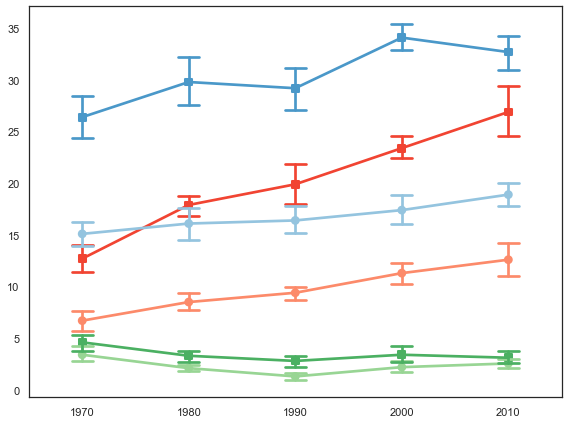

In [68]:
fig, ax= plt.subplots(1,1,figsize=(8,6))

y1=0


    
y2=0
blues=sns.color_palette("Blues",4)
reds=sns.color_palette("Reds",4)
greens=sns.color_palette("Greens",4)
gmap1={"male":blues[2], "female":reds[2], "unk":greens[2]}
gmap2={"male":blues[3], "female":reds[3], "unk":greens[3]}
gmap3={"male":blues[1], "female":reds[1], "unk":greens[1]}

for a_gender in period_stats.gender.unique():
    tempdf=yearcounts[yearcounts["gender"]==a_gender]
    
    ax=sns.pointplot(y="lang",x="decade",data=tempdf,color=gmap3[a_gender],marker=[".",".","."], capsize=0.2, ax=ax, label="kielet")#, dodge=True)#,palette=g_palette)
    ax=sns.pointplot(y="nat",x="decade",data=tempdf,color=gmap1[a_gender],markers=["s","s","s"], ax=ax, capsize=0.2, label="kansalaisuudet")#, dodge=True)#,palette=g_palette)

    #
    #ax[0].bar(tempdf["period"]-1.8,tempdf["workCount_g"],bottom=y1, width=2,color=gmap1[a_gender],alpha=0.7)
    #y1+=tempdf["workCount_g"].values 


    
#ax.legend(handles=all_handles, labels=fi_labels, ncol=2)
ax.set_ylabel(None)
ax.set_xlabel(None)
#ax.set_xticks(list(df_ln.period.unique()))
fig.tight_layout()

In [69]:

# load simpsons for plotting

s_list=glob.glob("../../data/simpson*")
print(s_list)

['../../data/simpson_nat_gender.csv', '../../data/simpson_nat.csv', '../../data/simpson_lang.csv', '../../data/simpson_lang_gender.csv']


In [70]:
s_n_g=pd.read_csv(s_list[0],sep="\t", index_col=0)
s_l_g=pd.read_csv(s_list[3],sep="\t", index_col=0)
s_n=pd.read_csv(s_list[1],sep="\t", index_col=0)
s_l=pd.read_csv(s_list[2],sep="\t", index_col=0)

In [71]:
[s_n_g,s_l_g]

[    year                                  gender  simpson  period
 0   1971  http://www.yso.fi/onto/kaunokki#female    0.770    1971
 1   1971    http://www.yso.fi/onto/kaunokki#male    0.844    1971
 2   1972  http://www.yso.fi/onto/kaunokki#female    0.713    1971
 3   1972    http://www.yso.fi/onto/kaunokki#male    0.820    1971
 4   1973  http://www.yso.fi/onto/kaunokki#female    0.731    1971
 ..   ...                                     ...      ...     ...
 95  2018    http://www.yso.fi/onto/kaunokki#male    0.846    2016
 96  2019  http://www.yso.fi/onto/kaunokki#female    0.847    2016
 97  2019    http://www.yso.fi/onto/kaunokki#male    0.851    2016
 98  2020  http://www.yso.fi/onto/kaunokki#female    0.816    2016
 99  2020    http://www.yso.fi/onto/kaunokki#male    0.851    2016
 
 [100 rows x 4 columns],
     year                                  gender  simpson  period
 0   1971  http://www.yso.fi/onto/kaunokki#female    0.550    1971
 1   1971    http://www.yso.fi/onto

In [72]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

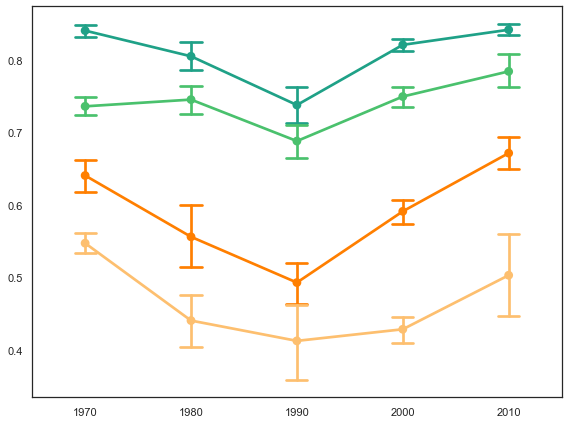

In [73]:
fig, ax= plt.subplots(1,1,figsize=(8,6))

y1=0


    
y2=0
blues=sns.color_palette("Blues",4)
reds=sns.color_palette("Reds",4)
greens=sns.color_palette("Greens",4)
viridis=sns.color_palette("viridis")
paired=sns.color_palette("Paired")
gmap1={"male":blues[2], "female":reds[2], "unk":greens[2]}
gmap2={"male":blues[3], "female":reds[3], "unk":greens[3]}
gmap3={"male":blues[1], "female":reds[1], "unk":greens[1]}
smap1={"male":viridis[3], "female":viridis[4]}#, "unk":greens[1]}
smap2={"male":paired[7],"female":paired[6]}
for a_df,c in zip([s_n_g,s_l_g], [smap1,smap2]):
    tempdf=add_decade(a_df)
    tempdf["gender"]=tempdf["gender"].apply(lambda x: x.split("#")[-1])
    for a_gender in ["male","female"]:
    
        tempdf1=tempdf[tempdf["gender"]==a_gender]
        #tempdf2=tempdf[tempdf["gender"].str.contains("male")]
    
        ax=sns.pointplot(y="simpson",x="decade",data=tempdf1,color=c[a_gender],marker=[".",".","."], capsize=0.2, ax=ax, label="kielet", alpha=0.8)#, dodge=True)#,palette=g_palette)
    #ax=sns.pointplot(y="simpson",x="decade",data=tempdf2,color=c,markers=["s","s","s"], ax=ax, capsize=0.2, label="kansalaisuudet")#, dodge=True)#,palette=g_palette)

    #
    #ax[0].bar(tempdf["period"]-1.8,tempdf["workCount_g"],bottom=y1, width=2,color=gmap1[a_gender],alpha=0.7)
    #y1+=tempdf["workCount_g"].values 


    
#ax.legend(handles=all_handles, labels=fi_labels, ncol=2)
ax.set_ylabel(None)
ax.set_xlabel(None)
#ax.set_xticks(list(df_ln.period.unique()))
fig.tight_layout()

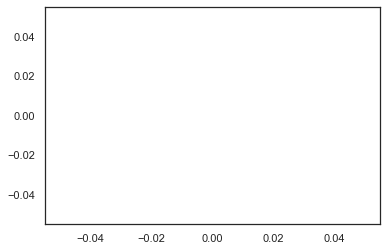

In [74]:
magma=sns.color_palette("magma")
fu = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
#smap2={"male":viridis[2],"female":magma[3]}
lmap1={"male":viridis[3], "female":magma[4], "male_n":viridis[2],"female_n":magma[3]}
mmap={"male":"o", "female":"o", "male_n":"s","female_n":"s"}
#legendmap={"n": ,"kansal., m": "kielet, n":smap1["female"], "kielet, m":}
my_handles = [fu(mmap[key], lmap1[key]) for key in mmap.keys()]
my_labels = list(["kansal., m" ,"kansal., n", "kielet, m", "kielet, n"])

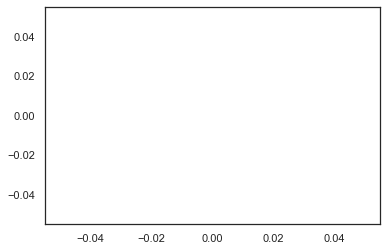

In [84]:
magma=sns.color_palette("magma")
fu = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
#smap2={"male":viridis[2],"female":magma[3]}
lmap2={"male":gmap1["male"], "female":gmap1["female"], "male_n":gmap3["male"],"female_n":gmap3["female"]}
mmap2={"male":"s", "female":"s", "male_n":"o","female_n":"o"}
#legendmap={"n": ,"kansal., m": "kielet, n":smap1["female"], "kielet, m":}
my_handles2 = [fu(mmap2[key], lmap2[key]) for key in mmap2.keys()]
my_labels2 = list(["kansalaisuudet, m" ,"kansalaisuudet, n", "kielet, m", "kielet, n"])

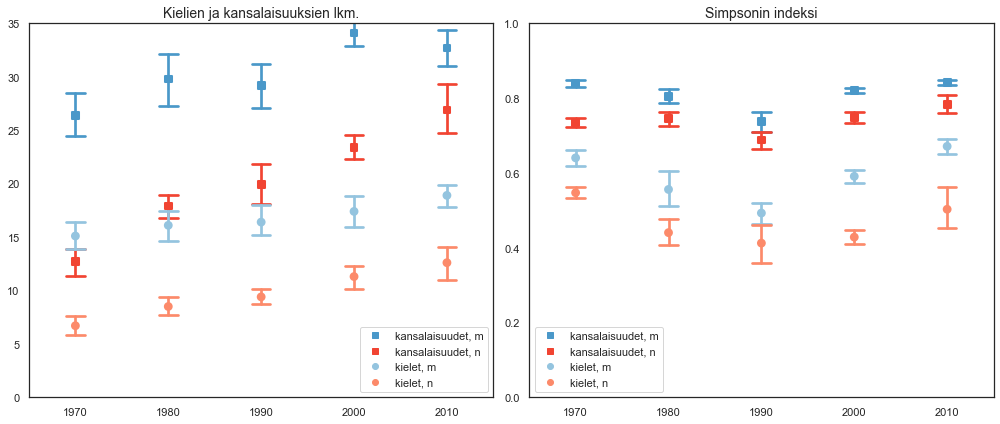

In [86]:
# add

fig, ax= plt.subplots(1,2,figsize=(14,6))

y1=0


    
y2=0
blues=sns.color_palette("Blues",4)
reds=sns.color_palette("Reds",4)
greens=sns.color_palette("Greens",4)

gmap1={"male":blues[2], "female":reds[2], "unk":greens[2]}
gmap2={"male":blues[3], "female":reds[3], "unk":greens[3]}
gmap3={"male":blues[1], "female":reds[1], "unk":greens[1]}

for a_gender in ["female","male"]:#period_stats.gender.unique():
    tempdf=yearcounts[yearcounts["gender"]==a_gender]
    
    ax0=sns.pointplot(y="lang",x="decade",data=tempdf,color=gmap3[a_gender],marker=[".",".","."], join=False,capsize=0.2, ax=ax[0], label="kielet")#, dodge=True)#,palette=g_palette)
    ax0=sns.pointplot(y="nat",x="decade",data=tempdf,color=gmap1[a_gender],markers=["s","s","s"], join=False,ax=ax[0], capsize=0.2, label="kansalaisuudet")#, dodge=True)#,palette=g_palette)

    #
    #ax[0].bar(tempdf["period"]-1.8,tempdf["workCount_g"],bottom=y1, width=2,color=gmap1[a_gender],alpha=0.7)
    #y1+=tempdf["workCount_g"].values 

smap1={"male":viridis[3], "female":magma[4]}#, "unk":greens[1]}
smap2={"male":viridis[2],"female":magma[3]}
#markers={"male":".",""}
mmarker="s"
for a_df,c in zip([s_n_g,s_l_g], [gmap1,gmap3]):
    tempdf=add_decade(a_df)
    tempdf["gender"]=tempdf["gender"].apply(lambda x: x.split("#")[-1])
    for a_gender in ["male","female"]:
    
        tempdf1=tempdf[tempdf["gender"]==a_gender]
        #tempdf2=tempdf[tempdf["gender"].str.contains("male")]
    
        ax1=sns.pointplot(y="simpson",x="decade",data=tempdf1,color=c[a_gender],markers=mmarker,join=False,  capsize=0.2, ax=ax[1], label=mmarker)#, dodge=True)#,palette=g_palette)
    #ax=sns.pointplot(y="simpson",x="decade",data=tempdf2,color=c,markers=["s","s","s"], ax=ax, capsize=0.2, label="kansalaisuudet")#, dodge=True)#,palette=g_palette)
    mmarker="o"
    #
    #ax[0].bar(tempdf["period"]-1.8,tempdf["workCount_g"],bottom=y1, width=2,color=gmap1[a_gender],alpha=0.7)
    #y1+=tempdf["workCount_g"].values 


   
    
#ax.legend(handles=all_handles, labels=fi_labels, ncol=2)
ax1.set_ylabel(None)
ax0.set_title("Kielien ja kansalaisuuksien lkm.", fontsize=14)
ax1.set_title("Simpsonin indeksi", fontsize=14)
legit=ax1.get_legend()
ax0.set_ylabel("")
#plt.set_xlabel(None)
ax1.set_xlabel(None)
ax0.set_xlabel(None)
ax1.set_ylim(0, 1)
ax0.set_ylim(0, 35)
#ax.set_xticks(list(df_ln.period.unique()))
lgd=ax1.legend(#loc='upper center', bbox_to_anchor=(0.5, 
           #                                   0.01), ncol=3,
           handles=my_handles2, labels=my_labels2)

lgd1=ax0.legend(#loc='upper center', bbox_to_anchor=(0.5, 
           #                                   0.01), ncol=3,
           handles=my_handles2, labels=my_labels2)
fig.tight_layout()
#fig.savefig('../../output/gender_diversity.png', bbox_extra_artists=(lgd,lgd1), bbox_inches='tight')

In [ ]:
legit